# Concurso de Modelización de problemas de empresas

## Interpretabilidad en riesgo de crédito.
### Management solutions.

La variable dependiente que se desea analizar es el “loan_status”. Dicha variable representa la probabilidad de impago de un cliente de una entidad financiera (donde el valor 1 representa impago).Las variables explicativas son:

- person_age: edad de la persona 
- person_income: el ingreso personal se refiere a las ganancias totales de un individuo provenientes de salarios, empresas de inversión y otras empresas.
- person_home_ownership: esta variable indica el tipo de posesión de una persona sobre su casa. Puede tomar el valor RENT = alquiler, OWN = en propiedad y MORTAGE = con hipoteca.
- person_emp_length: variable que indica los años que lleva trabajando una persona.
- loan_intent: variable que indica el propósito/ intención del préstamo.
- loan_grade: variable resultante de aplicar una fórmula que tiene en cuenta no solo el creditscore (puntuaje de crédito) sino tambien varios indicadores de riesgo de crédito extraidos del informe de crédito y solicitud de préstamo.
- loan_amnt: cantidad de crédito solicitado.
- loan_int_rate: tasas de interes de préstamo (en porcentaje)
- loan_percent_income: variable que mide el porcentaje de la relación deuda-ingreso (DTI), que es el porcentaje de su ingreso mensual bruto gastado en pagos de deuda. Este número se calcula dividiendo los costos totales de la deuda por mes por el ingreso mensual bruto del prestatario.
- cb_person_default_on_file: variable binaria que inidca si la persona no ha devuelto algun prestamo.
- cb_person_cred_hist_length: ???? historia crediticia de la persona.
- loan_status: estado del préstamo 






In [2]:

import operator as opt
import numpy as np 
import pandas as pd 
import os
import gc
from contextlib import contextmanager
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')           
%matplotlib inline     
sns.set(color_codes=True)

## Analisis exploratorio de los datos 

In [3]:
train = pd.read_csv("train.csv")
train.head(5)  

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,25,59000,MORTGAGE,6.0,MEDICAL,A,5100,8.32,0.09,N,3,0
1,35,26400,RENT,2.0,DEBTCONSOLIDATION,D,6000,16.29,0.23,Y,8,1
2,33,45000,RENT,13.0,EDUCATION,C,6800,11.22,0.15,Y,6,1
3,27,144000,MORTGAGE,4.0,DEBTCONSOLIDATION,C,21000,13.57,0.15,Y,8,0
4,31,43200,RENT,NaN,MEDICAL,B,1000,10.74,0.02,N,9,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  24435 non-null  int64  
 1   person_income               24435 non-null  int64  
 2   person_home_ownership       24435 non-null  object 
 3   person_emp_length           23759 non-null  float64
 4   loan_intent                 24435 non-null  object 
 5   loan_grade                  24435 non-null  object 
 6   loan_amnt                   24435 non-null  int64  
 7   loan_int_rate               22061 non-null  float64
 8   loan_percent_income         24435 non-null  float64
 9   cb_person_default_on_file   24435 non-null  object 
 10  cb_person_cred_hist_length  24435 non-null  int64  
 11  loan_status                 24435 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.2+ MB


Con un primer vistazo a la información podemos observar que hay datos faltantes (missings) en las variables person_emp_length y loan_int_rate


In [5]:
train.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [6]:
train.shape

(24435, 12)

tenemos 24435 filas y 12 columnas (variables)


In [7]:
duplicate_rows_train = train[train.duplicated()]
print("numero de duplicados: ", duplicate_rows_train.shape)
duplicate_rows_train.head(5)  
train.head(5)
train = train.drop_duplicates()

numero de duplicados:  (88, 12)


In [8]:
train.count()

person_age                    24347
person_income                 24347
person_home_ownership         24347
person_emp_length             23675
loan_intent                   24347
loan_grade                    24347
loan_amnt                     24347
loan_int_rate                 21984
loan_percent_income           24347
cb_person_default_on_file     24347
cb_person_cred_hist_length    24347
loan_status                   24347
dtype: int64

nos interesa no tener datos duplicados ?????? ver 


In [9]:
train.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              672
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2363
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

Creo que lo mejor va a ser que quitemos las imputaciones con missings porque justo las dos variables que tienen missing son las tasas de interes del prestamo ( es muy importante para el estudio). 

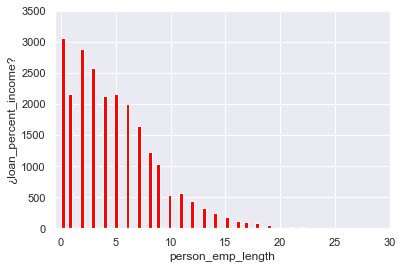

In [10]:
# Histograma de las cantidades de person_emp_length
n, bins, patches = plt.hist(train['person_emp_length'], bins='auto', color='red')
plt.xlabel("person_emp_length")
#No sé si lo de y es loan percent income
plt.ylabel("¿loan_percent_income?")
plt.xlim(-0.5,30)
plt.ylim(0,3500)
plt.show()

Creo que esta variable al tener 'solo' 676 missings podemos imputarlos por un valor ( por ejemplo la media o la mediana). Sin embargo, la otra variable con missings no podemos imputarlos ya que son 2374, la mejor opcion en este caso es eliminarlos del dataset. 

4.0


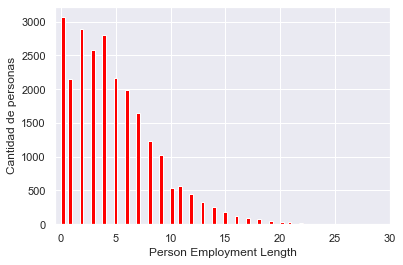

In [11]:
### Reemplazar los missings de la variable person_emp_length

median = train['person_emp_length'].median()
print(median)

# Imputamos los valores missings por la mediana de la variable person_emp_length
train['person_emp_length'].fillna(median, inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(train['person_emp_length'], bins='auto', color='red')
plt.xlabel("Person Employment Length")
plt.ylabel("Cantidad de personas")
plt.xlim(-0.5,30)
plt.show()

### Quitar los missings de la variable loan_int_rate

* Almacenamos los individuos con missings

In [12]:
indices = train[train['loan_int_rate'].isnull()].index

* Hacemos un nuevo conjunto de datos que no contiene missings.

In [13]:
train_clean = train.drop(indices)
train_clean.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [14]:
#train_new es train pero sin missings ni NaN.

train_clean.count()

person_age                    21984
person_income                 21984
person_home_ownership         21984
person_emp_length             21984
loan_intent                   21984
loan_grade                    21984
loan_amnt                     21984
loan_int_rate                 21984
loan_percent_income           21984
cb_person_default_on_file     21984
cb_person_cred_hist_length    21984
loan_status                   21984
dtype: int64

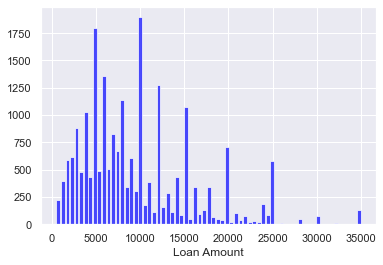

In [15]:
# Histograma de las cantidades de prestamo solicitadas
n, bins, patches = plt.hist(x=train_clean['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()


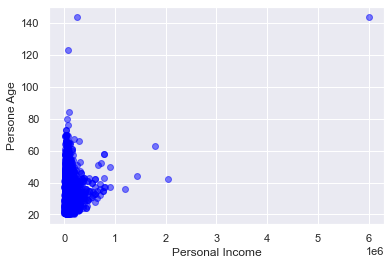

In [16]:
# Gráfico de Ingresos frente a la edad por persona.
plt.scatter(train_clean['person_income'], train_clean['person_age'],c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

### Outliers

In [17]:
Q1 = train_clean.quantile(0.25)
Q3 = train_clean.quantile(0.75)
IQR = Q3 - Q1
print(IQR) 

person_age                        7.00
person_income                 40807.50
person_emp_length                 5.00
loan_amnt                      7250.00
loan_int_rate                     5.57
loan_percent_income               0.14
cb_person_cred_hist_length        5.00
loan_status                       0.00
dtype: float64


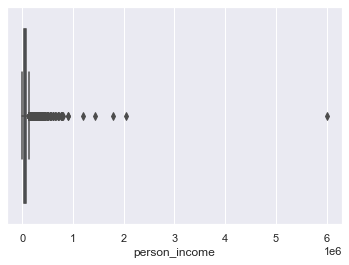

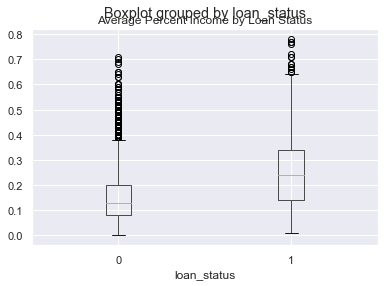

In [18]:
sns.boxplot(train_clean['person_income'])

train_clean.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
#plt.suptitle('')
plt.show()

Justo hay una persona con 600000000 euros y que tiene 144 años :////// sospechoso ademas no le dan el préstamo.


<AxesSubplot:xlabel='person_age'>

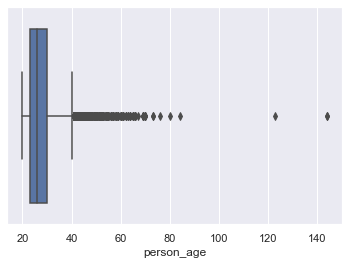

In [19]:
sns.boxplot(x=train_clean['person_age'])

ojo con esto tengo personas que tienen 123 y 144 años !!! estos son claramente outliers (los quitaria )

veamos ahora el tratamiento de outliers, nos interesan las variables edad y 

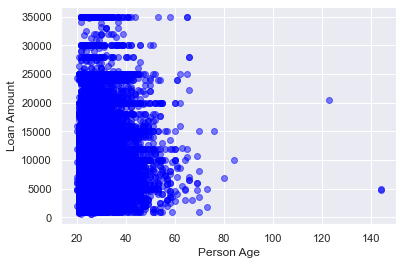

In [20]:

# grafico de dispersion de la edad frente a la cantidad de prestamo que solicitan 
plt.scatter(train_clean['person_age'], train_clean['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()



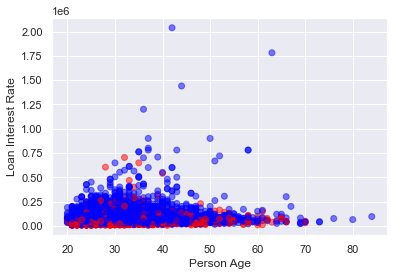

<AxesSubplot:xlabel='person_age'>

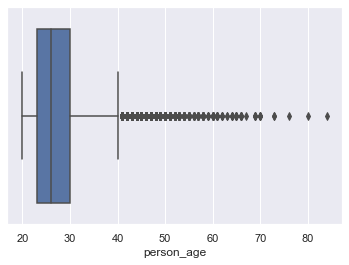

In [21]:
# quitamos las personas que tienen mas de 100 años 
#train_new es train_clean sin las personas de más de cien años

train_new = train_clean.drop(train_clean[train_clean['person_age'] > 100].index)

# grafico de dispersion de la edad frente a las tasas de interes
colors = ["blue","red"]
plt.scatter(train_new['person_age'], train_new['person_income'],
            c = train_new['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")

plt.show()

sns.boxplot(x=train_new['person_age'])

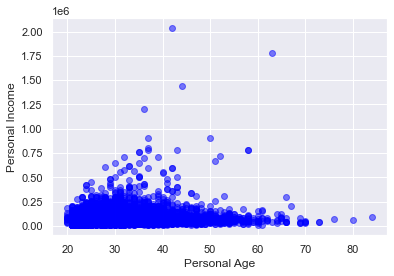

In [22]:
# Gráfico de Ingresos frente a la edad por persona.
plt.scatter(train_new['person_age'], train_new['person_income'],c='blue', alpha=0.5)
plt.xlabel('Personal Age')
plt.ylabel('Personal Income')
plt.show()

## RESTO DE OUTLIERS
Voy a identificar los outliers del resto de variables númericas


### Person_Income

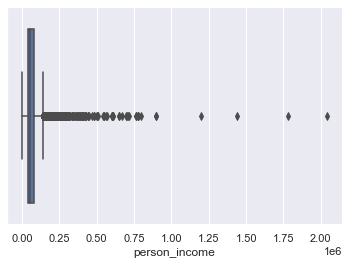

In [23]:
sns.boxplot(x=train_new['person_income'])

#train_clean es train sin missings ni NaN
#train_new es train_clean sin gente de más de cien años
# train2 es train_new sin gente con ingresos de más de cien mil 

train2 = train_new.drop(train_new[train_new['person_income'] > 1000000].index)


<AxesSubplot:xlabel='person_income'>

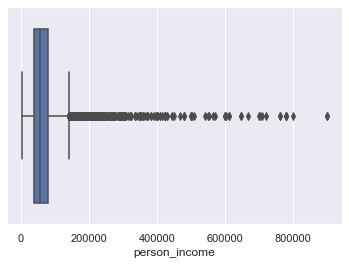

In [24]:
sns.boxplot(x=train2['person_income'])

### person_emp_length

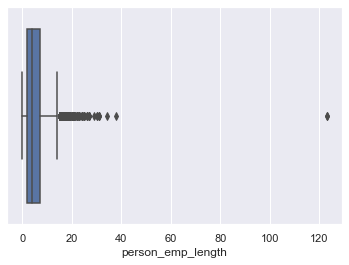

In [25]:
sns.boxplot(x=train2['person_emp_length'])

# train_clean es train sin missings ni NaN
# train_new es train_clean sin gente de más de cien años
# train2 es train_new sin gente con ingresos de más de cien mil
# train3 es train2 sin gente que haya trabajado más de 40 años

train3 = train2.drop(train2[train2['person_emp_length'] > 40].index)

<AxesSubplot:xlabel='person_emp_length'>

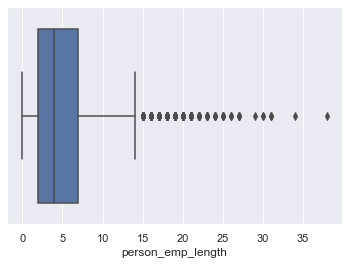

In [26]:
sns.boxplot(x=train3['person_emp_length'])

### loan_amnt

<AxesSubplot:xlabel='loan_amnt'>

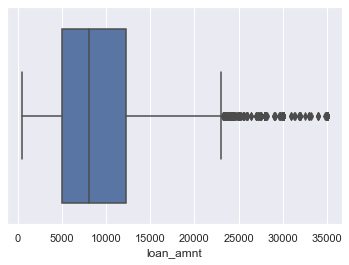

In [27]:
sns.boxplot(x=train3['loan_amnt'])


### loan_int_rate

<AxesSubplot:xlabel='loan_int_rate'>

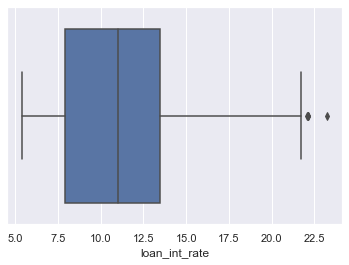

In [28]:
sns.boxplot(x=train3['loan_int_rate'])

### loan_percent_income

<AxesSubplot:xlabel='loan_percent_income'>

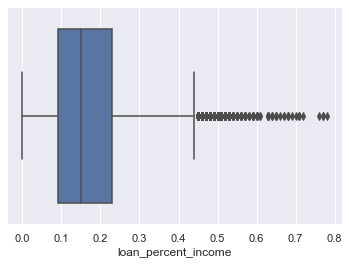

In [29]:
sns.boxplot(x=train3['loan_percent_income'])

### cb_person_cred_hist_length

<AxesSubplot:xlabel='cb_person_cred_hist_length'>

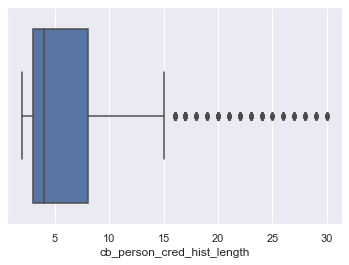

In [30]:
sns.boxplot(x=train3['cb_person_cred_hist_length'])

## Escalamos los datos (por hipotesis)

In [31]:
# train_clean es train sin missings ni NaN
# train_new es train_clean sin gente de más de cien años
# train2 es train_new sin gente con ingresos de más de cien mil
# train3 es train2 sin gente que haya trabajado más de 40 años

train3.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,25,59000,MORTGAGE,6.0,MEDICAL,A,5100,8.32,0.09,N,3,0
1,35,26400,RENT,2.0,DEBTCONSOLIDATION,D,6000,16.29,0.23,Y,8,1
2,33,45000,RENT,13.0,EDUCATION,C,6800,11.22,0.15,Y,6,1
3,27,144000,MORTGAGE,4.0,DEBTCONSOLIDATION,C,21000,13.57,0.15,Y,8,0
4,31,43200,RENT,4.0,MEDICAL,B,1000,10.74,0.02,N,9,0


In [32]:

#Select all data excluding 'object' to isolate numeric data
X_train_numeric = train3.select_dtypes(exclude = 'object')
X_train_numeric = X_train_numeric.drop(['loan_status'],axis=1)
# Set numeric dataframe columns
X_numeric_cols = X_train_numeric.columns
X_train_numeric.columns = X_numeric_cols

X_train_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21975 entries, 0 to 24434
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  21975 non-null  int64  
 1   person_income               21975 non-null  int64  
 2   person_emp_length           21975 non-null  float64
 3   loan_amnt                   21975 non-null  int64  
 4   loan_int_rate               21975 non-null  float64
 5   loan_percent_income         21975 non-null  float64
 6   cb_person_cred_hist_length  21975 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.3 MB


In [33]:
X_train_numeric.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,25,59000,6.0,5100,8.32,0.09,3
1,35,26400,2.0,6000,16.29,0.23,8
2,33,45000,13.0,6800,11.22,0.15,6
3,27,144000,4.0,21000,13.57,0.15,8
4,31,43200,4.0,1000,10.74,0.02,9


In [34]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Instantiate a standard scaler object
ss = StandardScaler()

# Fit and transform our numeric data to the ss object
X_train_numeric = pd.DataFrame(ss.fit_transform(X_train_numeric))
X_train_numeric.set_index(train3.index, inplace = True)

X_train_numeric.columns = X_numeric_cols
X_train_numeric.head()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,-0.440202,-0.142286,0.303754,-0.707965,-0.826019,-0.748453,-0.695433
1,1.184193,-0.839133,-0.697970,-0.566292,1.628690,0.560834,0.547522
2,0.859314,-0.441545,2.056771,-0.440360,0.067163,-0.187330,0.050340
3,-0.115323,1.674644,-0.197108,1.794927,0.790948,-0.187330,0.547522
4,0.534435,-0.480022,-0.197108,-1.353365,-0.080674,-1.403097,0.796114


## Dummificar

In [35]:
# Select only categorical data types

X_train_cat = train3.select_dtypes(include = 'object')
X_train_cat.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,MORTGAGE,MEDICAL,A,N
1,RENT,DEBTCONSOLIDATION,D,Y
2,RENT,EDUCATION,C,Y
3,MORTGAGE,DEBTCONSOLIDATION,C,Y
4,RENT,MEDICAL,B,N


In [36]:
# Dumificar TRAIN

X_train_cat = pd.get_dummies(train3, columns=['person_home_ownership'], prefix='', prefix_sep='')
X_train_cat = pd.get_dummies(X_train_cat, columns=['loan_intent'], prefix='', prefix_sep='')
X_train_cat = pd.get_dummies(X_train_cat, columns=['loan_grade'], prefix='', prefix_sep='')
X_train_cat = pd.get_dummies(X_train_cat, columns=['cb_person_default_on_file'], prefix='', prefix_sep='')
X_train_cat.head(5)

X_train_ = X_train_cat[['MORTGAGE','OTHER','OWN','RENT', 'DEBTCONSOLIDATION','EDUCATION','HOMEIMPROVEMENT','MEDICAL','PERSONAL','VENTURE','A','B','C','D','E','F','G','N','Y']]

X_train_.head(5)


,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,A,B,C,D,E,F,G,N,Y
0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [37]:
# Merge numerical data and categorical data

X_train_ = pd.merge(X_train_,train3.loan_status,left_index = True, right_index = True)

train = pd.merge(X_train_, X_train_numeric, left_index = True, right_index = True)
train.head()

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,N,Y,loan_status,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,-0.440202,-0.142286,0.303754,-0.707965,-0.826019,-0.748453,-0.695433
1,0,0,0,1,1,0,0,0,0,0,...,0,1,1,1.184193,-0.839133,-0.697970,-0.566292,1.628690,0.560834,0.547522
2,0,0,0,1,0,1,0,0,0,0,...,0,1,1,0.859314,-0.441545,2.056771,-0.440360,0.067163,-0.187330,0.050340
3,1,0,0,0,1,0,0,0,0,0,...,0,1,0,-0.115323,1.674644,-0.197108,1.794927,0.790948,-0.187330,0.547522
4,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0.534435,-0.480022,-0.197108,-1.353365,-0.080674,-1.403097,0.796114


### Voy a recontar cuantas variables he perdido por los outliers

In [38]:
train_new.count()

person_age                    21981
person_income                 21981
person_home_ownership         21981
person_emp_length             21981
loan_intent                   21981
loan_grade                    21981
loan_amnt                     21981
loan_int_rate                 21981
loan_percent_income           21981
cb_person_default_on_file     21981
cb_person_cred_hist_length    21981
loan_status                   21981
dtype: int64

In [39]:
train.count()

MORTGAGE                      21975
OTHER                         21975
OWN                           21975
RENT                          21975
DEBTCONSOLIDATION             21975
EDUCATION                     21975
HOMEIMPROVEMENT               21975
MEDICAL                       21975
PERSONAL                      21975
VENTURE                       21975
A                             21975
B                             21975
C                             21975
D                             21975
E                             21975
F                             21975
G                             21975
N                             21975
Y                             21975
loan_status                   21975
person_age                    21975
person_income                 21975
person_emp_length             21975
loan_amnt                     21975
loan_int_rate                 21975
loan_percent_income           21975
cb_person_cred_hist_length    21975
dtype: int64

## Correlaciones


,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,N,Y,loan_status,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
MORTGAGE,1.000000,-0.043543,-0.249607,-0.843925,0.026418,-0.002502,0.048086,-0.055757,0.016000,-0.021658,...,0.060897,-0.060897,-0.186244,0.037785,0.269264,0.226911,0.139008,-0.130622,-0.146502,0.026372
OTHER,-0.043543,1.000000,-0.015432,-0.052177,0.003949,-0.010403,0.000820,-0.002047,0.004917,0.003683,...,-0.013169,0.013169,0.014961,-0.005412,0.022330,-0.008685,0.011826,0.014444,0.007387,-0.003947
OWN,-0.249607,-0.015432,1.000000,-0.299098,-0.108180,0.011787,0.009476,-0.011179,0.000453,0.094414,...,0.005777,-0.005777,-0.107901,-0.006491,-0.050309,0.025619,-0.026174,-0.014532,0.052181,0.000359
RENT,-0.843925,-0.052177,-0.299098,1.000000,0.032696,-0.002901,-0.052622,0.061233,-0.016514,-0.030651,...,-0.061769,0.061769,0.240843,-0.033104,-0.240000,-0.236575,-0.123821,0.135090,0.115000,-0.025760
DEBTCONSOLIDATION,0.026418,0.003949,-0.108180,0.032696,1.000000,-0.216182,-0.155469,-0.206741,-0.195094,-0.200911,...,0.000104,-0.000104,0.073243,-0.002729,0.000408,-0.000616,-0.003492,0.001885,0.005617,-0.006474
EDUCATION,-0.002502,-0.010403,0.011787,-0.002901,-0.216182,1.000000,-0.178258,-0.237046,-0.223691,-0.230361,...,0.009297,-0.009297,-0.059404,-0.094322,-0.018598,-0.038207,-0.011356,-0.010315,-0.004571,-0.078259
HOMEIMPROVEMENT,0.048086,0.000820,0.009476,-0.052622,-0.155469,-0.178258,1.000000,-0.170474,-0.160869,-0.165666,...,-0.005871,0.005871,0.035200,0.077290,0.066067,0.032055,0.039041,0.012536,-0.020125,0.060620
MEDICAL,-0.055757,-0.002047,-0.011179,0.061233,-0.206741,-0.237046,-0.170474,1.000000,-0.213923,-0.220301,...,-0.004377,0.004377,0.059233,0.015711,-0.049185,-0.004707,-0.027040,0.012145,0.011781,0.012397
PERSONAL,0.016000,0.004917,0.000453,-0.016514,-0.195094,-0.223691,-0.160869,-0.213923,1.000000,-0.207890,...,-0.004440,0.004440,-0.023109,0.032974,0.010683,0.009356,0.003433,0.001316,-0.003204,0.031847
VENTURE,-0.021658,0.003683,0.094414,-0.030651,-0.200911,-0.230361,-0.165666,-0.220301,-0.207890,1.000000,...,0.003870,-0.003870,-0.074992,-0.011347,0.003675,0.009511,0.006896,-0.015108,0.007303,-0.006213


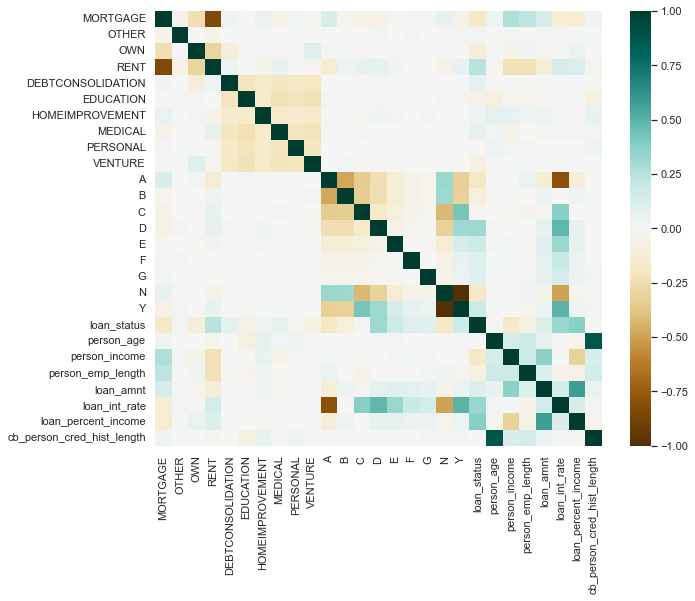

In [40]:
plt.figure(figsize=(10,8))
correlaciones = train.corr()
sns.heatmap(correlaciones,cmap="BrBG")
correlaciones

Se puede ver claramente una gran correlacion entre 'cb_person_cred_hist_length' y 'person_age' esto tiene una explicacion clara ya que a medida que la edad aumenta el historial de creditos es mayor . Tambien entre 'loan_amnt' y 'loan_percent_income es una relacion directa como hemos explicado arriba.

En segundo plano podríamos estudiar la relacion entre 'loan_percent_income'+'loan_int_rate' con 'loan_status'

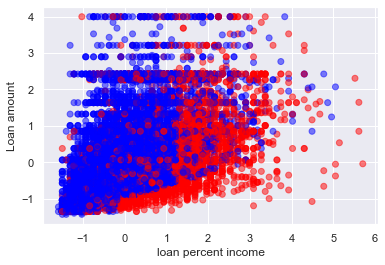

In [41]:
# grafico de dispersion de la edad frente a las tasas de interes
colors = ["blue","red"]
plt.scatter(train['loan_percent_income'], train['loan_amnt'],
            c = train['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("loan percent income")
plt.ylabel("Loan amount")
plt.show()

# Modelos

# Arbol de decisión

In [89]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

feature_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate'
               , 'loan_percent_income', 'cb_person_cred_hist_length', 'MORTGAGE', 'OTHER', 'OWN', 'RENT', 'DEBTCONSOLIDATION'
               , 'EDUCATION' , 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'N', 'Y']
target_cols = ['loan_status']

X = train[feature_cols]
Y = train[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier(max_depth=12, min_samples_split=2, min_samples_leaf=1, random_state=42, criterion='entropy')
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9278022144698923


In [43]:
y_train.head()

,loan_status
17734,0
1718,0
17525,0
10081,0
6068,0


In [44]:
preds_proba = clf.predict_proba(X_test)
prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(auc)

0.9058774043847275


## Feature engineering

* Voy a suprimir variables cuya correlación de las variables es > 0.95

In [45]:

# train_clean es train sin missings ni NaN
# train_new es train_clean sin gente de más de cien años
# train2 es train_new sin gente con ingresos de más de cien mil
# train3 es train2 sin gente que haya trabajado más de 40 años
# X_train_numeric es train3 sin las variables de nombres y normalizadas
# X_train_cat es train3 dumificado
# X_train_ es X_train_cat solo con las variables binarias
# X_train_ es X_train_ y train3
# train es X_train_ y X_train_numeric
# train_d es train sin 'N'


,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,G,Y,loan_status,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
MORTGAGE,1.000000,-0.043543,-0.249607,-0.843925,0.026418,-0.002502,0.048086,-0.055757,0.016000,-0.021658,...,0.008414,-0.060897,-0.186244,0.037785,0.269264,0.226911,0.139008,-0.130622,-0.146502,0.026372
OTHER,-0.043543,1.000000,-0.015432,-0.052177,0.003949,-0.010403,0.000820,-0.002047,0.004917,0.003683,...,-0.002478,0.013169,0.014961,-0.005412,0.022330,-0.008685,0.011826,0.014444,0.007387,-0.003947
OWN,-0.249607,-0.015432,1.000000,-0.299098,-0.108180,0.011787,0.009476,-0.011179,0.000453,0.094414,...,-0.003718,-0.005777,-0.107901,-0.006491,-0.050309,0.025619,-0.026174,-0.014532,0.052181,0.000359
RENT,-0.843925,-0.052177,-0.299098,1.000000,0.032696,-0.002901,-0.052622,0.061233,-0.016514,-0.030651,...,-0.005998,0.061769,0.240843,-0.033104,-0.240000,-0.236575,-0.123821,0.135090,0.115000,-0.025760
DEBTCONSOLIDATION,0.026418,0.003949,-0.108180,0.032696,1.000000,-0.216182,-0.155469,-0.206741,-0.195094,-0.200911,...,-0.007664,-0.000104,0.073243,-0.002729,0.000408,-0.000616,-0.003492,0.001885,0.005617,-0.006474
EDUCATION,-0.002502,-0.010403,0.011787,-0.002901,-0.216182,1.000000,-0.178258,-0.237046,-0.223691,-0.230361,...,-0.002230,-0.009297,-0.059404,-0.094322,-0.018598,-0.038207,-0.011356,-0.010315,-0.004571,-0.078259
HOMEIMPROVEMENT,0.048086,0.000820,0.009476,-0.052622,-0.155469,-0.178258,1.000000,-0.170474,-0.160869,-0.165666,...,0.009987,0.005871,0.035200,0.077290,0.066067,0.032055,0.039041,0.012536,-0.020125,0.060620
MEDICAL,-0.055757,-0.002047,-0.011179,0.061233,-0.206741,-0.237046,-0.170474,1.000000,-0.213923,-0.220301,...,0.001870,0.004377,0.059233,0.015711,-0.049185,-0.004707,-0.027040,0.012145,0.011781,0.012397
PERSONAL,0.016000,0.004917,0.000453,-0.016514,-0.195094,-0.223691,-0.160869,-0.213923,1.000000,-0.207890,...,0.001538,0.004440,-0.023109,0.032974,0.010683,0.009356,0.003433,0.001316,-0.003204,0.031847
VENTURE,-0.021658,0.003683,0.094414,-0.030651,-0.200911,-0.230361,-0.165666,-0.220301,-0.207890,1.000000,...,-0.002047,-0.003870,-0.074992,-0.011347,0.003675,0.009511,0.006896,-0.015108,0.007303,-0.006213


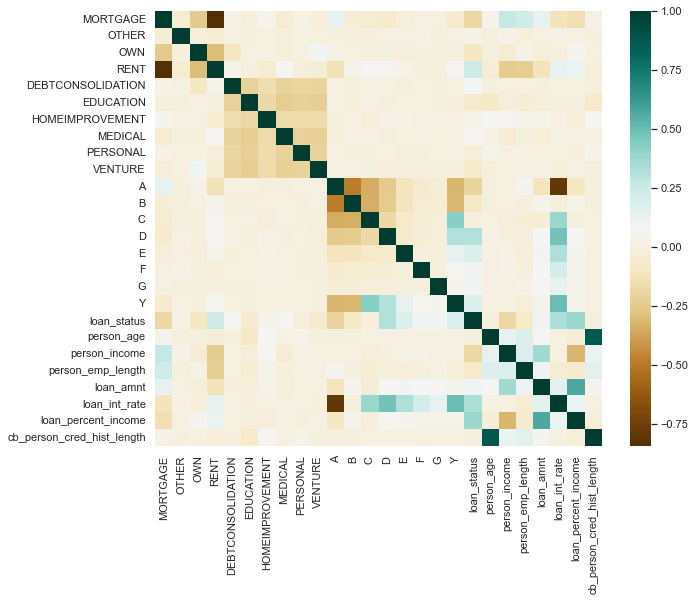

In [45]:
train_d = train.drop(['N'],axis=1)
plt.figure(figsize=(10,8))
correlaciones = train_d.corr()
sns.heatmap(correlaciones,cmap="BrBG")
correlaciones

In [46]:
feature_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate'
               , 'loan_percent_income', 'MORTGAGE', 'OTHER', 'OWN', 'RENT', 'DEBTCONSOLIDATION', 'cb_person_cred_hist_length',
                'EDUCATION' , 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y']
target_cols = ['loan_status']

X = train_d[feature_cols]
Y = train_d[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier(max_depth=11, min_samples_split=2, min_samples_leaf=1, random_state=42)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9253753981495526


In [47]:
X.count()

person_age                    21975
person_income                 21975
person_emp_length             21975
loan_amnt                     21975
loan_int_rate                 21975
loan_percent_income           21975
MORTGAGE                      21975
OTHER                         21975
OWN                           21975
RENT                          21975
DEBTCONSOLIDATION             21975
cb_person_cred_hist_length    21975
EDUCATION                     21975
HOMEIMPROVEMENT               21975
MEDICAL                       21975
PERSONAL                      21975
VENTURE                       21975
A                             21975
B                             21975
C                             21975
D                             21975
E                             21975
F                             21975
G                             21975
Y                             21975
dtype: int64

In [48]:
preds_proba = clf.predict_proba(X_test)
prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(auc)

0.8902526490139517


* Dropping the binary 'N' variable has increased the model´s performance by 0.001.

# The Logistic Regression Model

In [49]:
# train_clean es train sin missings ni NaN
# train_new es train_clean sin gente de más de cien años
# train2 es train_new sin gente con ingresos de más de cien mil
# train3 es train2 sin gente que haya trabajado más de 40 años
# X_train_numeric es train3 sin las variables de nombres y normalizadas
# X_train_cat es train3 dumificado
# X_train_ es X_train_cat solo con las variables binarias
# X_train_ es X_train_ y train3
# train es X_train_ y X_train_numeric
# train_d es train sin 'N'
# x_train es train sin 'loan_status'

from sklearn.linear_model import LinearRegression


feature_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate'
               , 'loan_percent_income', 'MORTGAGE', 'OTHER', 'OWN', 'RENT', 'DEBTCONSOLIDATION', 'cb_person_cred_hist_length',
                'EDUCATION' , 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y', 'N']
target_cols = ['loan_status']

X = train[feature_cols]
Y = train[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [50]:
train.count()

MORTGAGE                      21975
OTHER                         21975
OWN                           21975
RENT                          21975
DEBTCONSOLIDATION             21975
EDUCATION                     21975
HOMEIMPROVEMENT               21975
MEDICAL                       21975
PERSONAL                      21975
VENTURE                       21975
A                             21975
B                             21975
C                             21975
D                             21975
E                             21975
F                             21975
G                             21975
N                             21975
Y                             21975
loan_status                   21975
person_age                    21975
person_income                 21975
person_emp_length             21975
loan_amnt                     21975
loan_int_rate                 21975
loan_percent_income           21975
cb_person_cred_hist_length    21975
dtype: int64

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Instantiate a regression object
lr = LogisticRegression(random_state=42)

# fit the training sets to model 
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
preds_proba = lr.predict_proba(X_test)

print(lr, '\n',classification_report(y_test, lr.predict(X_test)))

LogisticRegression(random_state=42) 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      5137
           1       0.78      0.57      0.66      1456

    accuracy                           0.87      6593
   macro avg       0.83      0.76      0.79      6593
weighted avg       0.86      0.87      0.86      6593



In [52]:
print(preds_proba)

[[0.97183027 0.02816973]
 [0.23967582 0.76032418]
 [0.55277967 0.44722033]
 ...
 [0.55700652 0.44299348]
 [0.73211662 0.26788338]
 [0.86522861 0.13477139]]


In [53]:
### Visually scoring credit models
from sklearn.metrics import roc_curve, roc_auc_score

prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(auc)

0.8791267618890745


## Feature Engineering

### Variable Merging

In [54]:
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,MORTGAGE,OTHER,OWN,RENT,...,VENTURE,A,B,C,D,E,F,G,Y,N
12030,-0.765081,1.589142,0.554185,0.378196,0.218079,-0.748453,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
19175,1.509072,-0.762180,-1.198832,0.189298,0.372076,1.776600,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
18204,-0.927520,-0.655302,-0.197108,0.346713,-0.015996,1.589559,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1
20174,-0.927520,-0.762180,-0.697970,-0.566292,0.436755,0.280272,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
16428,-1.089960,-0.494984,-0.447539,2.424586,0.532233,3.927571,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [55]:
# Create every possible bivariate combination to be tested for feature engineering
from itertools import combinations

column_list = X_train.columns
interactions = list(combinations(column_list, 2))

In [56]:
X_test.count()

person_age                    6593
person_income                 6593
person_emp_length             6593
loan_amnt                     6593
loan_int_rate                 6593
loan_percent_income           6593
MORTGAGE                      6593
OTHER                         6593
OWN                           6593
RENT                          6593
DEBTCONSOLIDATION             6593
cb_person_cred_hist_length    6593
EDUCATION                     6593
HOMEIMPROVEMENT               6593
MEDICAL                       6593
PERSONAL                      6593
VENTURE                       6593
A                             6593
B                             6593
C                             6593
D                             6593
E                             6593
F                             6593
G                             6593
Y                             6593
N                             6593
dtype: int64

In [57]:
# Iterate through interaction list to perform linear regression for each possible engineered features
interaction_dict = {}
for interaction in interactions:
    X_train_int = X_train
    X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
    lr3 = LinearRegression()
    lr3.fit(X_train_int, y_train)
    interaction_dict[lr3.score(X_train_int, y_train)] = interaction

In [58]:
X_train_int.count()

person_age                    15382
person_income                 15382
person_emp_length             15382
loan_amnt                     15382
loan_int_rate                 15382
loan_percent_income           15382
MORTGAGE                      15382
OTHER                         15382
OWN                           15382
RENT                          15382
DEBTCONSOLIDATION             15382
cb_person_cred_hist_length    15382
EDUCATION                     15382
HOMEIMPROVEMENT               15382
MEDICAL                       15382
PERSONAL                      15382
VENTURE                       15382
A                             15382
B                             15382
C                             15382
D                             15382
E                             15382
F                             15382
G                             15382
Y                             15382
N                             15382
int                           15382
dtype: int64

In [59]:
# Sort engineered features by best performers, top performers to be selected for final regression
interaction_dict = {}
top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction_dict[interaction])

In [60]:
X_train_int.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,MORTGAGE,OTHER,OWN,RENT,...,A,B,C,D,E,F,G,Y,N,int
12030,-0.765081,1.589142,0.554185,0.378196,0.218079,-0.748453,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
19175,1.509072,-0.762180,-1.198832,0.189298,0.372076,1.776600,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
18204,-0.927520,-0.655302,-0.197108,0.346713,-0.015996,1.589559,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
20174,-0.927520,-0.762180,-0.697970,-0.566292,0.436755,0.280272,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
16428,-1.089960,-0.494984,-0.447539,2.424586,0.532233,3.927571,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [61]:
# Add the top two interaction features (which exclude a categorical variable) to existing DF for feature engineered model
#X_train_int = X
X_train_int['re_loan'] = X_train_int['RENT'] * X_train_int['loan_percent_income']
X_train_int['MORTGAGE_loan'] = X_train_int['MORTGAGE'] * X_train_int['loan_percent_income']
X_train_int['DEBTCONSOLIDATION_D'] = X_train_int['DEBTCONSOLIDATION'] * X_train_int['D']
X_train_int['OWN_D'] = X_train_int['OWN'] * X_train_int['D']
X_train_int['INCOME_loan'] = X_train_int['person_income'] * X_train_int['loan_percent_income']

X_test['re_loan'] = X_test['RENT'] * X_test['loan_percent_income']
X_test['MORTGAGE_loan'] = X_test['MORTGAGE'] * X_test['loan_percent_income']
X_test['DEBTCONSOLIDATION_D'] = X_test['DEBTCONSOLIDATION'] * X_test['D']
X_test['OWN_D'] = X_test['OWN'] * X_test['D']
X_test['INCOME_loan'] = X_test['person_income'] * X_test['loan_percent_income']

X_train_int.head()
X_test.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,MORTGAGE,OTHER,OWN,RENT,...,E,F,G,Y,N,re_loan,MORTGAGE_loan,DEBTCONSOLIDATION_D,OWN_D,INCOME_loan
20173,0.371996,0.520359,0.053323,-0.330170,-0.089914,-0.841974,1,0,0,0,...,0,0,0,0,1,-0.000000,-0.841974,0,0,-0.438129
12533,0.209556,-0.722934,-0.697970,-0.503326,1.219059,0.280272,0,0,0,1,...,0,0,0,1,0,0.280272,0.000000,0,0,-0.202618
426,-0.765081,-0.633926,-1.198832,0.220781,0.649270,1.308997,0,0,0,1,...,0,0,0,1,0,1.308997,0.000000,0,0,-0.829808
23000,0.047117,-0.762180,0.053323,-0.593840,-0.311669,0.186752,0,0,0,1,...,0,0,0,0,1,0.186752,0.000000,0,0,-0.142338
15181,1.021754,-0.113365,2.056771,-0.172755,-0.108394,-0.280851,0,0,0,1,...,0,0,0,0,1,-0.280851,-0.000000,0,0,0.031839


In [64]:
X_train_int.count()

person_age                    15382
person_income                 15382
person_emp_length             15382
loan_amnt                     15382
loan_int_rate                 15382
loan_percent_income           15382
MORTGAGE                      15382
OTHER                         15382
OWN                           15382
RENT                          15382
DEBTCONSOLIDATION             15382
cb_person_cred_hist_length    15382
EDUCATION                     15382
HOMEIMPROVEMENT               15382
MEDICAL                       15382
PERSONAL                      15382
VENTURE                       15382
A                             15382
B                             15382
C                             15382
D                             15382
E                             15382
F                             15382
G                             15382
Y                             15382
N                             15382
re_loan                       15382
MORTGAGE_loan               

In [67]:
X_train_int = X_train_int.drop(['int'],axis=1)

lr4 = LogisticRegression()
lr4.fit(X_train_int, y_train)
lr4.score(X_train_int, y_train)
preds_proba = lr4.predict_proba(X_test)

In [68]:
#X_train_int = X_train_int.drop(['int'])

lr4 = LogisticRegression()
lr4.fit(X_train_int, y_train)
lr4.score(X_train_int, y_train)
preds_proba = lr4.predict_proba(X_test)

prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(f'ROC AUC Score: {100*auc}%')

ROC AUC Score: 89.52087794432548%


* Variable merging has increased the model´s performance by 0.0002

### Polynomial feature engineering

In [69]:

from sklearn.preprocessing import PolynomialFeatures

poly_dict = {}
for feature in X_train_int.columns:
    for p in range(2, 5):
        X_train_poly = X_train
        X_train_poly['sq'] = X_train_poly[feature] ** p
        lr = LinearRegression()
        lr.fit(X_train_poly, y_train)
        poly_dict[lr.score(X_train_poly, y_train)] = [feature, p]
    
poly_dict[max(poly_dict.keys())]

['loan_amnt', 2]

In [70]:
# X_train_final es X_train_int pero con una variable más que es el resultado de ^2 a 'loan_amnt'

X_train_final = X_train_int
X_train_final['edu_cubed'] = X_train_final['loan_amnt'] ** 2
X_test['edu_cubed'] = X_test['loan_amnt'] ** 2

#_train_final.drop('sq', axis = 1, inplace = True)
X_train_final.count()

person_age                    15382
person_income                 15382
person_emp_length             15382
loan_amnt                     15382
loan_int_rate                 15382
loan_percent_income           15382
MORTGAGE                      15382
OTHER                         15382
OWN                           15382
RENT                          15382
DEBTCONSOLIDATION             15382
cb_person_cred_hist_length    15382
EDUCATION                     15382
HOMEIMPROVEMENT               15382
MEDICAL                       15382
PERSONAL                      15382
VENTURE                       15382
A                             15382
B                             15382
C                             15382
D                             15382
E                             15382
F                             15382
G                             15382
Y                             15382
N                             15382
re_loan                       15382
MORTGAGE_loan               

In [71]:
X_test.count()

person_age                    6593
person_income                 6593
person_emp_length             6593
loan_amnt                     6593
loan_int_rate                 6593
loan_percent_income           6593
MORTGAGE                      6593
OTHER                         6593
OWN                           6593
RENT                          6593
DEBTCONSOLIDATION             6593
cb_person_cred_hist_length    6593
EDUCATION                     6593
HOMEIMPROVEMENT               6593
MEDICAL                       6593
PERSONAL                      6593
VENTURE                       6593
A                             6593
B                             6593
C                             6593
D                             6593
E                             6593
F                             6593
G                             6593
Y                             6593
N                             6593
re_loan                       6593
MORTGAGE_loan                 6593
DEBTCONSOLIDATION_D 

In [72]:
lr = LogisticRegression()
lr.fit(X_train_final, y_train)
lr.score(X_train_final, y_train)
preds_proba = lr.predict_proba(X_test)

In [73]:
prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(auc)

0.9031590732607863


* Polynomial has increased the result by 0.01

Ahora creo que debemos hacer lo mismo con las variables del test para ver si la AUC es mas alta. 

### Variable Dropping

<AxesSubplot:>

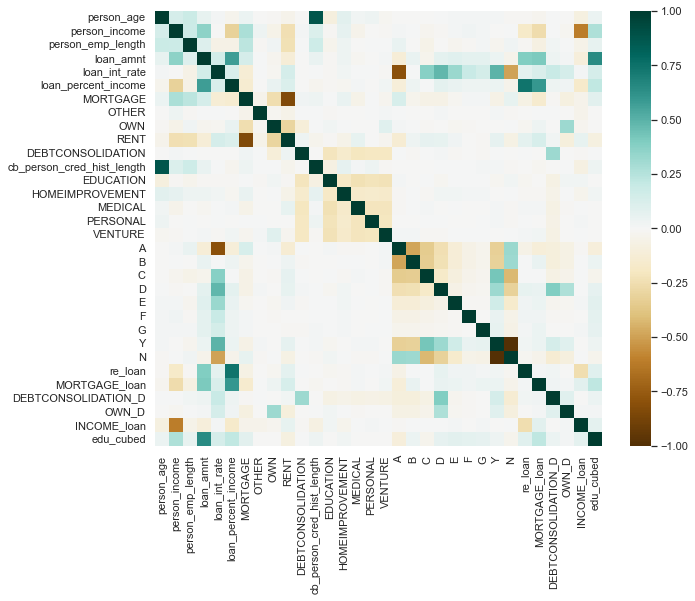

In [74]:
train_2 = X_train_final.drop(['N'],axis=1)
X_test = X_test.drop(['N'], axis=1)
#train_2 = train_2.drop(['MORTGAGE'], axis=1)

plt.figure(figsize=(10,8))
correlaciones = X_train_final.corr()
sns.heatmap(correlaciones,cmap="BrBG")
#correlaciones


In [75]:
lr = LogisticRegression()
lr.fit(train_2, y_train)
lr.score(train_2, y_train)
preds_proba = lr.predict_proba(X_test)

In [76]:
prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(auc)

0.903189690395258


* It has no positive effect

### Data splitting by decision tree

In [77]:
from sklearn.tree import _tree

nn=0
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print ("def tree({}):" .format(", " .join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            table = 'X_train'
            name = table+"['"+feature_name[node]+"']"
            

            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            def increment():
                global nn
                nn=nn+1
            increment()
            print ("{}return 'Node_{}'".format(indent, nn))

    recurse(0, 1)

In [78]:
X_train.count()

person_age                    15382
person_income                 15382
person_emp_length             15382
loan_amnt                     15382
loan_int_rate                 15382
loan_percent_income           15382
MORTGAGE                      15382
OTHER                         15382
OWN                           15382
RENT                          15382
DEBTCONSOLIDATION             15382
cb_person_cred_hist_length    15382
EDUCATION                     15382
HOMEIMPROVEMENT               15382
MEDICAL                       15382
PERSONAL                      15382
VENTURE                       15382
A                             15382
B                             15382
C                             15382
D                             15382
E                             15382
F                             15382
G                             15382
Y                             15382
N                             15382
int                           15382
re_loan                     

In [79]:
X_train = X_train.drop(['int'], axis=1)
X_train = X_train.drop(['sq'], axis=1)

In [80]:


clf = DecisionTreeClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, random_state=42, criterion='entropy')
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
columns = X_train.columns

tree_to_code(clf,columns)

    if X_train['re_loan'] <= 1.2622371912002563:
        if X_train['loan_int_rate'] <= 0.9187648296356201:
            if X_train['person_income'] <= -0.9760222136974335:
                if X_train['INCOME_loan'] <= 0.18592190742492676:
                    return 'Node_1'
                else:  # if X_train['INCOME_loan'] > 0.18592190742492676
                    return 'Node_2'
            else:  # if X_train['person_income'] > -0.9760222136974335
                if X_train['loan_int_rate'] <= 0.05484289675951004:
                    return 'Node_3'
                else:  # if X_train['loan_int_rate'] > 0.05484289675951004
                    return 'Node_4'
        else:  # if X_train['loan_int_rate'] > 0.9187648296356201
            if X_train['C'] <= 0.5:
                if X_train['DEBTCONSOLIDATION'] <= 0.5:
                    return 'Node_5'
                else:  # if X_train['DEBTCONSOLIDATION'] > 0.5
                    return 'Node_6'
            else:  # if X_train['C'] >

In [81]:
def tree(X_train):
    if X_train['re_loan'] <= 1.2622371912002563:
        if X_train['loan_int_rate'] <= 0.9187648296356201:
            if X_train['person_income'] <= -0.9760222136974335:
                if X_train['INCOME_loan'] <= 0.18592190742492676:
                    return 'Node_26'
                else:  # if X_train['INCOME_loan'] > 0.18592190742492676
                    return 'Node_27'
            else:  # if X_train['person_income'] > -0.9760222136974335
                if X_train['loan_int_rate'] <= 0.05484289675951004:
                    return 'Node_28'
                else:  # if X_train['loan_int_rate'] > 0.05484289675951004
                    return 'Node_29'
        else:  # if X_train['loan_int_rate'] > 0.9187648296356201
            if X_train['C'] <= 0.5:
                if X_train['DEBTCONSOLIDATION'] <= 0.5:
                    return 'Node_30'
                else:  # if X_train['DEBTCONSOLIDATION'] > 0.5
                    return 'Node_31'
            else:  # if X_train['C'] > 0.5
                if X_train['person_income'] <= -0.9802118241786957:
                    return 'Node_32'
                else:  # if X_train['person_income'] > -0.9802118241786957
                    return 'Node_33'
    else:  # if X_train['re_loan'] > 1.2622371912002563
        return 'Node_34'